In [ ]:
from io import StringIO

with open('vertex_positions.txt', 'r') as file:
    # Read the entire file into a string
    file_contents = file.read()
    # Create a file-like object in memory
    file_in_memory = StringIO(file_contents)

FileNotFoundError: ignored

In [ ]:
import re 
import numpy as np
def get_vertex_positions(frame_num):
    for line in file_in_memory:
        if f"Frame {frame_num}" in line:
             vertex_positions = re.search('\[(.+?)\]', line).group(1)
             vertex_positions = np.fromstring(vertex_positions, sep=', ')
             if vertex_positions is not None:
                 vertex_positions = vertex_positions.reshape(-1, 3)
                 return vertex_positions
    # if the frame_num is not found in the file, return None
    print(f"Frame {frame_num} not found in the file")
    return None

In [ ]:
!pip install dask_ml
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import dask.array as da
import dask_ml.decomposition as dd
import pandas as pd

#Number of vertices in flag
c = 231

#Number of frames
n = 20000

#Wind speed and direction as vector
wind_speed = 1.63
wind_direction = np.array([1, 0, 0])

#Create matrix X for vertex positions
X = np.zeros((3*c, n))
for t in range(n):
  vertex_positions = get_vertex_positions(t)
  x_t = vertex_positions.flatten()
  X[:, t] = x_t

#Add wind speed and direction as columns in X
wind_speed = np.full((3*c,1), wind_speed)
wind_direction = np.tile(wind_direction, (3*c,3))
X = np.column_stack((X, wind_speed, wind_direction))

#Convert the numpy array to dask array
X = da.from_array(X, chunks=(3*c+2, 1000))

#Apply PCA to X using Dask
pca_X = dd.PCA(n_components=256, svd_solver='randomized')
Z = pca_X.fit_transform(X)

#Compute the final transformation
Z = Z.compute()

#Convert the numpy array to a pandas DataFrame
Z_df = pd.DataFrame(Z)

# Save the DataFrame to a csv file
Z_df.to_csv("Z.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# Load data
Z = pd.read_csv("/content/drive/MyDrive/Z.csv", header=None).values

# Normalize data
scaler = StandardScaler()
Z_norm = scaler.fit_transform(Z)

# Create inputs and outputs
X = np.zeros((len(Z_norm) - 1, Z_norm.shape[1], 2))
Y = np.zeros((len(Z_norm) - 1, Z_norm.shape[1]))

for i in range(1, len(Z_norm)):
    X[i-1,:,0] = Z_norm[i-1,:]
    X[i-1,:,1] = Z_norm[i,:]
    Y[i-1,:] = Z_norm[i,:]

# Shuffle and split data
ss = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2)
train_idx, test_idx = next(ss.split(X))
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(Y.shape[1])
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32)

# Save model
model.save("flag_model.h5")



In [1]:
from google.colab import files

# Download the saved model to your local machine
files.download('/content/drive/MyDrive/flag_model.h5')

FileNotFoundError: ignored

In [2]:
from tensorflow.keras.models import load_model

# load the model
model = load_model('/content/drive/MyDrive/flag_model.h5')

# save the weights to a file
model.save_weights('my_weights.h5')

In [ ]:
import numpy as np
import pandas as pd

model = load_model('/content/drive/MyDrive/flag_model.h5')
# Load the pre-processed PCA data
z = pd.read_csv('/content/drive/MyDrive/Z.csv', header=None).to_numpy()

# Reshape the data into a shape that can be fed into the model
X_test = np.reshape(z, (z.shape[0], 256, 2))

# Create Y_test by passing X_test through the model
Y_test = model.predict(X_test)


ValueError: ignored

2/2 [==============================] - 1s 116ms/step


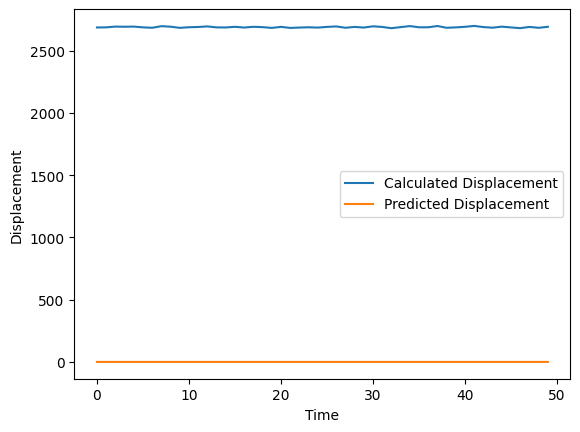

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

model = load_model('/content/drive/MyDrive/flag_model.h5')


# Generate test dataset of random vertices
num_vertices = 256
num_timesteps = 50

test_data = np.random.rand(num_timesteps, num_vertices, 2)

# Predict displacement using model
predicted_displacement = model.predict(test_data)

# Calculate displacement using wind speed and direction
wind_speed = 10.0
wind_direction = np.array([1.0, 0.0])

displacement = np.zeros((num_timesteps, 2))

for t in range(num_timesteps):
    for i in range(num_vertices):
        vertex = test_data[t][i]
        displacement[t] += vertex + wind_speed * wind_direction

# Plot displacement over time
fig, ax = plt.subplots()

ax.plot(np.arange(num_timesteps), displacement[:, 0], label="Calculated Displacement")
ax.plot(np.arange(num_timesteps), predicted_displacement[:, 0], label="Predicted Displacement")

ax.set_xlabel("Time")
ax.set_ylabel("Displacement")

ax.legend()

plt.show()



In [ ]:
import numpy as np
import tensorflow as tf

# Load the vertex positions from the file
with open('vertex_positions.txt', 'r') as f:
    positions = []
    for line in f:
        # Skip lines that don't contain vertex positions
        if not line.startswith('Frame'):
            continue
        
        # Extract the vertex positions from the line
        positions.append([float(coord) for coord in line.strip().split(' ')[1:]])
    
# Convert the list of positions to a numpy array
positions = np.array(positions)

# Load the trained model
model = tf.keras.models.load_model('trained_model.h5')

# Normalize the vertex positions
mean_pos = np.mean(positions, axis=0)
std_pos = np.std(positions, axis=0)
positions = (positions - mean_pos) / std_pos

# Predict the displacement using the trained model
predicted_displacement = model.predict(positions)

# Denormalize the predicted displacement
predicted_displacement = predicted_displacement * std_pos

# Plot the predicted displacement over time
import matplotlib.pyplot as plt
t = np.arange(predicted_displacement.shape[0])
fig, ax = plt.subplots()
ax.plot(t, predicted_displacement[:, 0], label='x displacement')
ax.plot(t, predicted_displacement[:, 1], label='y displacement')
ax.legend()
plt.show()

In [ ]:
!pip install gpt-code-ui

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.2/381.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00
  Created wheel for snakemq: filename=snakeMQ-1.6-py3-none-any.whl size=51349 sha256=a07c498641cd84a0fb9fddb9f4171276b6302b2f3029e3578ff21b11a4de44c1
  Stored in directory: /root/.cache/pip/wheels/4e/62/e8/126a7a0a5ef8090ed22d1eddfb2f8407a04f8588f3548f5a22
Successfully built snakemq
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that